In [1]:
import sys
if "../" not in sys.path: sys.path.append("../")

from os import path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from scipy import stats

import seaborn as sns
# sns.set_palette("deep")
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams["figure.facecolor"] = "white"

from tqdm.notebook import tqdm

%matplotlib inline

%load_ext autoreload
%autoreload 2

from analysis_helpers import *

from eye_plotting import AREA_ORDERING, AREA_ABBREV
from experiment.cre_line import match_cre_line, CRE_ORDERING, CRE_COLORS

from saccade_config import *

In [2]:
cells_spont = load_additional_data(LOADED_CLASSIFIED_CELLS_SPONTANEOUS_CSV, in_data_dir=False, index_col=0)
cells_all = load_additional_data(LOADED_CLASSIFIED_CELLS_CSV, in_data_dir=False, index_col=0)

In [53]:
cells = load_additional_data(LOADED_CLASSIFIED_CELLS_SPONTANEOUS_CSV, in_data_dir=False, index_col=0)
# cells = load_additional_data(LOADED_CLASSIFIED_CELLS_CSV, in_data_dir=False, index_col=0)
CRE_PLOT_KEY = "cre_abbrev"
cells[CRE_PLOT_KEY] = cells[CRE_PLOT_KEY].apply(lambda x: x.replace(" ", "")) # backwards compatability; make "Cux2; Ai93" -> "Cux2;Ai93"
print(f"There are {len(cells):,} total cells.")

cells["session_indices_str"] = cells["session_indices"]
cells["session_indices"] = cells["session_indices"].apply(eval)
add_cell_df_columns(cells)
cells.head()

There are 27,912 total cells.


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_total,n_left,...,depth_trunc,cortical_layer,is_sr,is_sr_ds,is_sr_miura,is_sr_ds_miura,preferred_direction,preferred_direction_miura,sr_label,sr_label_miura
specimen_id,,,,,,,,,,,,,,,,,,,,,
578468534,Sst-IRES-Cre; Ai148(TIT2L-GC6f-ICL-tTA2),Sst;Ai148,275,VISp,573720506,"((573720508, 1),)",0,0.338075,18,10,...,200,4,False,False,False,False,0,NaN,No response,No response
662132676,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1;Ai93,350,VISal,637113170,"((637668816, 1), (637990755, 0), (638862121, 1))",0,0.230175,17,4,...,200,4,False,False,False,False,0,NaN,No response,No response
662132725,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1;Ai93,350,VISal,637113170,"((637668816, 2), (637990755, 1), (638862121, 2))",0,0.622075,17,4,...,200,4,False,False,False,False,0,NaN,No response,No response
662132701,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1;Ai93,350,VISal,637113170,"((637668816, 3), (637990755, 2), (638862121, 4))",0,0.150150,17,4,...,200,4,False,False,False,False,0,NaN,No response,No response
662132765,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1;Ai93,350,VISal,637113170,"((637668816, 4), (637990755, 3), (638862121, 6))",0,0.386075,17,4,...,200,4,False,False,False,False,0,NaN,No response,No response


In [16]:
# Create CSV file of sessions analyzed
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from eye_tracking.eye_tracking import get_saccade_magnitude_direction

boc = BrainObservatoryCache(manifest_file=BRAIN_OBSERVATORY_CACHE_MANIFEST_FILE)
n_analyzed_cells_in_session = {}

for session_indices in cells["session_indices"].values:
    for session_id, _ in session_indices:
        if session_id not in n_analyzed_cells_in_session:
            n_analyzed_cells_in_session[session_id] = 1
        else:
            n_analyzed_cells_in_session[session_id] += 1
    
session_analysis_info = pd.DataFrame(columns=["ophys_session_id", "was_analyzed", "n_cells_total", "n_cells_analyzed", "n_saccades", "n_saccades_nasal", "n_saccades_temporal"])


for ophys_exp in tqdm(boc.get_ophys_experiments(require_eye_tracking=True)):
    session_id = ophys_exp["id"]
    data = load_data_by_session_id(session_id)
    was_analyzed = session_id in n_analyzed_cells_in_session
    index = len(session_analysis_info)

    session_analysis_info.at[index, "ophys_session_id"] = session_id
    session_analysis_info.at[index, "was_analyzed"] = was_analyzed
    if data is not None:
        session_analysis_info.at[index, "n_cells_total"] = len(data["cell_specimen_ids"])
        session_analysis_info.at[index, "n_cells_analyzed"] = n_analyzed_cells_in_session.get(session_id, 0)

        # Count saccades
        n, n_nas, n_tem = len(data["saccades"]), 0, 0

        for ss, se in data["saccades"]:
            _, d = get_saccade_magnitude_direction(data["eye_tracking"], ss, se)
            if d == "L": n_nas += 1
            elif d == "R": n_tem += 1
        
        session_analysis_info.at[index, "n_saccades"] = n
        session_analysis_info.at[index, "n_saccades_nasal"] = n_nas
        session_analysis_info.at[index, "n_saccades_temporal"] = n_tem

save_file = path.abspath(path.join("..", "data", "session_analysis_info.csv"))
session_analysis_info.to_csv(save_file)
session_analysis_info.head(10)

  0%|          | 0/837 [00:00<?, ?it/s]

,ophys_session_id,was_analyzed,n_cells_total,n_cells_analyzed,n_saccades,n_saccades_nasal,n_saccades_temporal
0,649409874,True,26,26,180,68,111
1,663488086,True,35,27,95,14,62
2,604328043,True,52,52,253,96,145
3,577225417,True,10,10,93,39,46
4,627823695,True,21,21,519,269,249
5,588535615,True,14,14,611,348,236
6,650389887,True,181,181,40,16,21
7,662960692,True,91,91,155,60,91
8,546963704,True,196,196,259,111,128
9,570006683,True,18,18,186,97,80


In [17]:
# Table of cre lines, abbreviations, and number of cells
df_cre_info = pd.DataFrame(index=CRE_ORDERING)
df_cre_info["cre_full"] = [match_cre_line(cre).get_full_cre_name() for cre in CRE_ORDERING]
df_cre_info["cre_abbreviation"] = CRE_ORDERING
df_cre_info["num_sessions"] = 0
df_cre_info["all_cells"] = [set() for _ in df_cre_info.index]
df_cre_info["all_mice_ids"] = [set() for _ in df_cre_info.index]

for data in load_data(tqdm_desc="Loading session information"):
    cre_line = match_cre_line(data)
    cre = str(cre_line)
    df_cre_info.at[cre, "num_sessions"] += 1
    df_cre_info.at[cre, "all_cells"].update(data["cell_specimen_ids"])
    df_cre_info.at[cre, "all_mice_ids"].add(data["metadata"]["specimen_name"])

df_cre_info["num_cells_total"] = df_cre_info["all_cells"].apply(len)
df_cre_info.drop("all_cells", axis=1, inplace=True)
df_cre_info["num_mice_total"] = df_cre_info["all_mice_ids"].apply(len)
df_cre_info.drop("all_mice_ids", axis=1, inplace=True)
df_cre_info["num_cells_analyzed"] = cells[CRE_PLOT_KEY].value_counts().reindex(df_cre_info.index)
df_cre_info.head(-1)

Loading session information:   0%|          | 0/818 [00:00<?, ?it/s]

,cre_full,cre_abbreviation,num_sessions,num_cells_total,num_mice_total,num_cells_analyzed
Emx1;Ai93,Emx1-IRES-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Emx1;Ai93,83,8866,17,5020
Slc17a7;Ai93,Slc17a7-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Slc17a7;Ai93,124,8512,24,7707
Slc17a7;Ai94,Slc17a7-IRES2-Cre; Camk2a-tTA; Ai94(TITL-GCaMP6s),Slc17a7;Ai94,6,817,1,817
Cux2;Ai93,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,121,10181,32,6991
Rorb;Ai93,Rorb-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Rorb;Ai93,61,4738,18,3485
Scnn1a;Ai93,Scnn1a-Tg3-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Scnn1a;Ai93,21,1513,6,838
Nr5a1;Ai93,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1;Ai93,71,2122,20,1353
Rbp4;Ai93,Rbp4-Cre_KL100; Camk2a-tTA; Ai93(TITL-GCaMP6f),Rbp4;Ai93,72,1649,21,1399
Fezf2;Ai148,Fezf2-CreER; Ai148(TIT2L-GC6f-ICL-tTA2),Fezf2;Ai148,25,1346,8,1338
Tlx3;Ai148,Tlx3-Cre_PL56; Ai148(TIT2L-GC6f-ICL-tTA2),Tlx3;Ai148,12,979,3,979


In [18]:
df_cre_info.to_csv("/Users/chase/Desktop/cre_info.csv")

In [19]:
miura_sig = ((cells["wilcoxon_signed_rank_p"] < 5e-2) | (cells["ranksum_p_by_direction"] < 5e-2))
miura_sig.sum(), miura_sig.mean() * 100

(20697, 63.67523997046517)

In [20]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [21]:
# Correct for comparisons
method = "fdr_bh"
alpha = 0.1
miura_sig = (
    (multipletests(cells["wilcoxon_signed_rank_p"], alpha=alpha, method=method)[1] < 0.05)
    | (multipletests(cells["ranksum_p_by_direction"], alpha=alpha, method=method)[1] < 0.05)
)
miura_sig.sum(), miura_sig.mean() * 100

(17187, 52.87656903765691)

In [22]:
method = "bonferroni"
alpha = 0.1

p_corr = multipletests(cells["p_value"], alpha=alpha, method=method)[1]
is_sr = (p_corr < 0.05)# | (p_corr > 0.95)

print(is_sr.mean())

print((cells["p_value"] < 5e-4).mean())

0.039933546640413486
0.08306669948314054


In [23]:
multipletests(cells["p_value"], alpha=0.5, method="bonferroni")

(array([False, False, False, ..., False, False, False]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 2.1324753566864807e-05,
 1.5382722126507506e-05)

<BarContainer object of 13 artists>

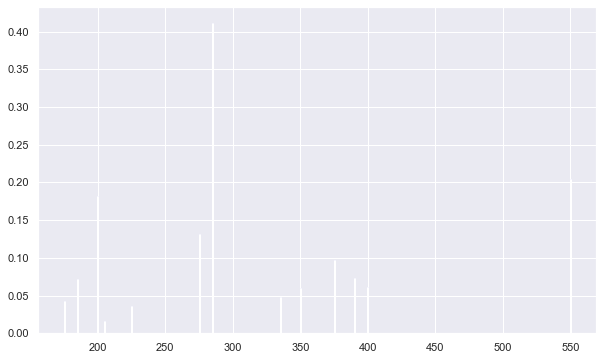

In [24]:
# print(cells[cells.targeted_structure == "VISp"].groupby("depth")["is_sr"].value_counts())
depths = []
rates = []
counts = []

for depth in cells[cells.targeted_structure == "VISp"]["depth"].unique():
    df = cells[(cells.targeted_structure == "VISp") & (cells.depth == depth)]
    n = len(df)
    n_sr = np.count_nonzero(df.is_sr)
    depths.append(depth)
    rates.append(n_sr/n)
    counts.append(n)

fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.bar(depths, rates, color="blue")

Text(0.5, 1.0, 'V1 neurons')

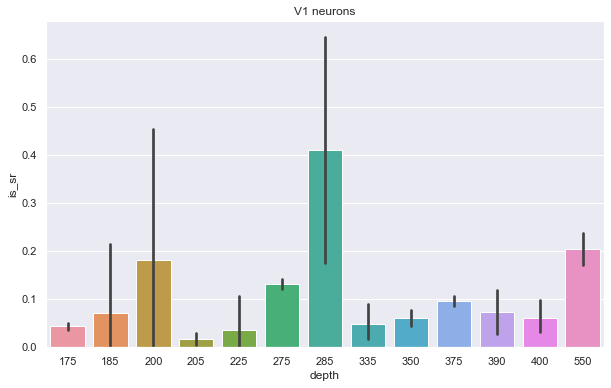

In [25]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
sns.barplot(data=cells[cells.targeted_structure == "VISp"], x="depth", y="is_sr", ax=ax)
ax.set_title("V1 neurons")

In [26]:
n_sr = cells["is_sr"].sum()
n_sr_e = (cells["response_classification"] == 1).sum()
n_sr_s = (cells["response_classification"] == -1).sum()
n_sr_ds_T = ((cells["response_classification"] == 1) & (cells["preferred_direction"] == 1)).sum()
n_sr_ds_N = ((cells["response_classification"] == 1) & (cells["preferred_direction"] == -1)).sum()
n_sr_not_ds = ((cells["response_classification"] == 1) & (cells["preferred_direction"] == 0)).sum()
print(f"{n_sr:,} out of {len(cells):,} ({n_sr/len(cells)*100:.1f}%) cells were saccade-responsive, with {n_sr_e:,} ({n_sr_e/n_sr*100:.1f}%) having an enhanced response and {n_sr_s:,} ({n_sr_s/n_sr*100:.1f}%) having a suppressed response.")
print(f"out of {n_sr_e:,} saccade-responsive cells with an enhanced response, {n_sr_ds_T:,} ({n_sr_ds_T/n_sr_e*100:.1f}%) preferred temporal saccades, {n_sr_ds_N:,} ({n_sr_ds_N/n_sr_e*100:.1f}%) preferred nasal saccades, and {n_sr_not_ds:,} ({n_sr_not_ds/n_sr_e*100:.1f}%) were not direction-selective.")

3,068 out of 32,504 (9.4%) cells were saccade-responsive, with 2,700 (88.0%) having an enhanced response and 368 (12.0%) having a suppressed response.
out of 2,700 saccade-responsive cells with an enhanced response, 1,474 (54.6%) preferred temporal saccades, 310 (11.5%) preferred nasal saccades, and 916 (33.9%) were not direction-selective.


([<matplotlib.patches.Wedge at 0x7fc841e44c10>,
 [Text(1.051991860090071, 0.321423593260097, 'SR'),
  Text(-1.0519918450431458, -0.3214236425073899, 'Not SR')],
 [Text(0.5738137418673115, 0.1753219599600529, '9.4%'),
  Text(-0.5738137336598976, -0.17532198682221264, '90.6%')])

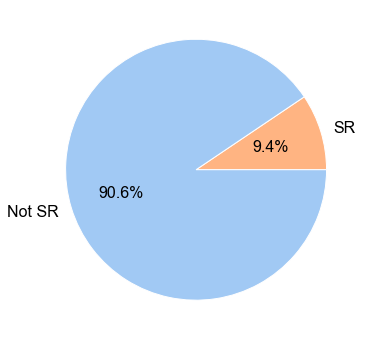

In [27]:
pie_data = [
    (cells["is_sr"]).sum(),
    (~cells["is_sr"]).sum(),
]
pie_labels = ["SR", "Not SR"]
plt.figure(figsize=(6, 6), facecolor="white")
colors = reversed(sns.color_palette("pastel")[:len(pie_data)]) # Reversed so it matches coloring below lol
plt.pie(pie_data, labels=pie_labels, colors=colors, autopct="%.1f%%", textprops=dict(fontsize=16, color="black"))

In [54]:
label_none = "No response"
label_enhanced = "Enhanced: No DS"
label_suppressed = "Suppressed"
label_nasal = "Enhanced: Nasal"
label_temporal = "Enhanced: Temporal"

cells["sr_label"] = label_none
cells.loc[(cells["response_classification"] == 1) & ~(cells["is_sr_ds"]), "sr_label"] = label_enhanced
cells.loc[(cells["response_classification"] == -1), "sr_label"] = label_suppressed
cells.loc[(cells["is_sr"]) & (cells["preferred_direction"] == -1), "sr_label"] = label_nasal
cells.loc[(cells["is_sr"]) & (cells["preferred_direction"] == 1), "sr_label"] = label_temporal

cells["sr_label_miura"] = label_none
cells.loc[(cells["is_sr_miura"]) & ~(cells["is_sr_ds_miura"]), "sr_label_miura"] = "SR"
cells.loc[(cells["is_sr_miura"]) & (cells["preferred_direction_miura"] == -1), "sr_label_miura"] = label_nasal
cells.loc[(cells["is_sr_miura"]) & (cells["preferred_direction_miura"] == 1), "sr_label_miura"] = label_temporal

print(cells["sr_label"].value_counts())
print()
print(cells["sr_label_miura"].value_counts())

SR_LABELS = [
    (label_none, "gray"),
    (label_suppressed, "purple"),
    (label_enhanced, "green"),
    (label_nasal, "b"),
    (label_temporal, "r"),
]

No response           26629
Enhanced: No DS         603
Enhanced: Temporal      342
Suppressed              257
Enhanced: Nasal          81
Name: sr_label, dtype: int64

No response           26619
SR                      965
Enhanced: Temporal      266
Enhanced: Nasal          62
Name: sr_label_miura, dtype: int64


In [55]:
metrics, cells_and_metrics = load_metrics(cells=cells)
cells_and_metrics.head()

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,8,12,16,20,32,53,69) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


18,833/27,912 cells have associated metrics


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_total,n_left,...,run_stat_dg,responsive_rundg,run_corr_mean,run_corr_A_lw,run_corr_B_lw,run_corr_C_lw,responsive_run,dg_all_RidgeRegress_CC,cluster_id,DSI_pref_tf
578468534,Sst-IRES-Cre; Ai148(TIT2L-GC6f-ICL-tTA2),Sst;Ai148,275,VISp,573720506,"((573720508, 1),)",0,0.338075,18,10,...,1.480479,True,0.055676,0.055676,NaN,NaN,True,0.373354,NaN,0.535288
662132676,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1;Ai93,350,VISal,637113170,"((637668816, 1), (637990755, 0), (638862121, 1))",0,0.230175,17,4,...,0.677645,False,NaN,0.080190,0.037799,0.020111,False,0.231180,13.0,0.041488
662132725,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1;Ai93,350,VISal,637113170,"((637668816, 2), (637990755, 1), (638862121, 2))",0,0.622075,17,4,...,NaN,False,NaN,0.133402,0.073409,0.005590,False,0.155377,14.0,0.517113
662132701,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1;Ai93,350,VISal,637113170,"((637668816, 3), (637990755, 2), (638862121, 4))",0,0.150150,17,4,...,1.010549,False,NaN,0.125876,-0.000081,0.028529,False,0.127663,8.0,0.352039
662132765,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1;Ai93,350,VISal,637113170,"((637668816, 4), (637990755, 3), (638862121, 6))",0,0.386075,17,4,...,4.916891,False,NaN,0.081661,0.026101,-0.002438,False,0.386058,9.0,0.908677


# Fraction of responsive cells in session vs saccade frequency

In [56]:
mean_sacc_freq = []
frac_sr = []
cre = []

for data in load_data():
    start, end = data["start_end"]
    n_sacc = len(data["saccades"])
    c = str(match_cre_line(data))
    freq = n_sacc / ((end-start)/FRAME_RATE)
    cell_ids = data["cell_specimen_ids"]
    n_sr = int(cells["is_sr"][cells.index.isin(cell_ids)].sum())
    frac = n_sr / len(cell_ids)

    mean_sacc_freq.append(freq)
    frac_sr.append(frac)
    cre.append(c)

KeyboardInterrupt: 

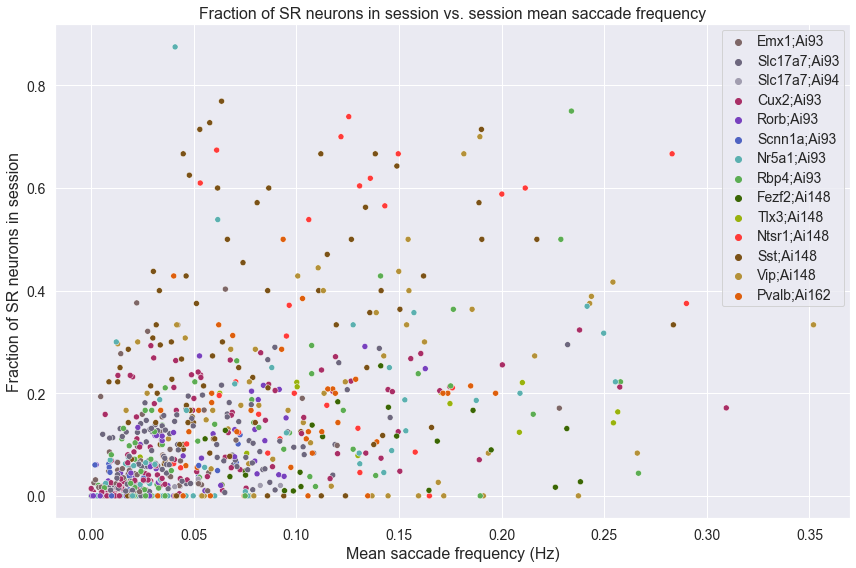

In [31]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

sns.scatterplot(x=mean_sacc_freq, y=frac_sr, ax=ax, hue=cre, palette=CRE_COLORS, hue_order=CRE_ORDERING)
# plt.setp(ax.get_legend().get_title(), text="Cre", fontsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize=14)
plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
ax.set_xlabel("Mean saccade frequency (Hz)", fontsize=16)
ax.set_ylabel("Fraction of SR neurons in session", fontsize=16)
ax.set_title("Fraction of SR neurons in session vs. session mean saccade frequency", fontsize=16)
fig.tight_layout()
savefig(fig, "frac_sr_neurons_vs_mean_sacc_freq.png")

# Sort based on peak times

In [230]:
window_radius = 30 # 1 sec
trace_len = 2*window_radius+1
cell_mean_traces = []
cell_mean_traces_train = []
cell_mean_traces_test = []
cell_ds = []

np.random.seed(1)

for specimen_id, row in tqdm(cells[cells["is_sr"]].iterrows(), total=int(cells["is_sr"].sum())):
    ds = None
    if row["preferred_direction"] == -1:
        ds = "L"
    elif row["preferred_direction"] == 1:
        ds = "R"
    
    # Compute all in all sessions
    traces = []
    
    for sid, cell_index in row["session_indices"]:
        data = load_data_by_session_id(sid)

        for ss, se in data["saccades"]:
            mag, dir = get_saccade_magnitude_direction(data["eye_tracking"], ss, se)
            
            if ds is None or dir == ds: # Filter by direction selectivity
                times = slice(ss-window_radius, ss+window_radius+1)
                trace = data["dff_traces"][cell_index, times]
                if len(trace) == trace_len:
                    traces.append(trace)

    random_idx = np.random.permutation(len(traces))
    mid = len(traces)//2
    train_idx, test_idx = random_idx[:mid], random_idx[mid:]

    traces = np.array(traces)
    cell_mean_traces.append(np.mean(traces, axis=0))
    cell_mean_traces_train.append(np.mean(traces[train_idx], axis=0))
    cell_mean_traces_test.append(np.mean(traces[test_idx], axis=0))
    cell_ds.append(ds)

cell_mean_traces = np.array(cell_mean_traces)
cell_mean_traces_train = np.array(cell_mean_traces_train)
cell_mean_traces_test = np.array(cell_mean_traces_test)

  0%|          | 0/3071 [00:00<?, ?it/s]

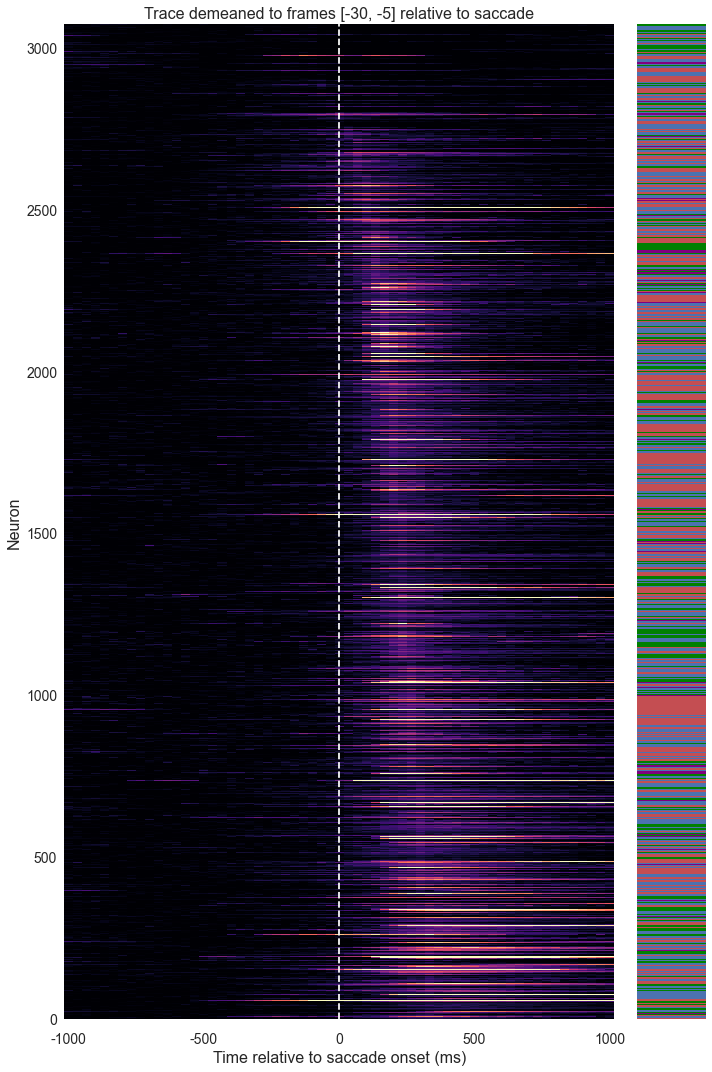

In [231]:
with plt.style.context("seaborn"):
    a = cell_mean_traces - cell_mean_traces[:, window_radius-30:window_radius-5].mean(axis=1, keepdims=True)
    peak_dff_window = slice(window_radius-3, window_radius+11) # 3 frames before onset to 10 frames after
    peak_dff_frame = np.argmax(a[:, peak_dff_window], axis=1)
    sort_idx = np.argsort(-peak_dff_frame)

    fig, (ax_traces, ax_labels) = plt.subplots(ncols=2, figsize=(10, 15), facecolor="white", gridspec_kw={'width_ratios': [8, 1]})
    cax = ax_traces.pcolormesh(a[sort_idx], cmap="magma", vmin=0, vmax=np.percentile(a, 99))
    # cb = fig.colorbar(cax, pad=0.015, label="dF/F")
    set_major_minor_ticks(ax_traces, window_radius, center=window_radius+0.5) # 0.5 center so it aligns at the center of the color cell
    ax_traces.axvline(window_radius+0.5, color="white", linestyle="dashed")
    ax_traces.set_ylabel("Neuron", fontsize=16)
    ax_traces.set_xlabel("Time relative to saccade onset (ms)", fontsize=16)
    plt.setp((ax_traces.get_xticklabels(), ax_traces.get_yticklabels()), fontsize=14)
    ax_traces.set_title("Trace demeaned to frames [-30, -5] relative to saccade", fontsize=16)


    # Plot labels
    label_to_color = []
    colors = []
    for l, c in SR_LABELS:
        if l is not label_none:
            label_to_color.append(l)
            colors.append(c)
    labels = []
    for specimen_id, row in cells[cells["is_sr"]].iterrows():
        labels.append(label_to_color.index(row["sr_label"]))
    cmap = matplotlib.colors.ListedColormap(colors)
    labels = np.array(labels).reshape((len(labels), 1))
    # labels = np.ones((len(labels), 200)) * labels
    ax_labels.imshow(labels, cmap=cmap)
    ax_labels.set_aspect("auto")
    ax_labels.grid(False)
    ax_labels.xaxis.set_visible(False)
    ax_labels.yaxis.set_visible(False)
    fig.tight_layout()

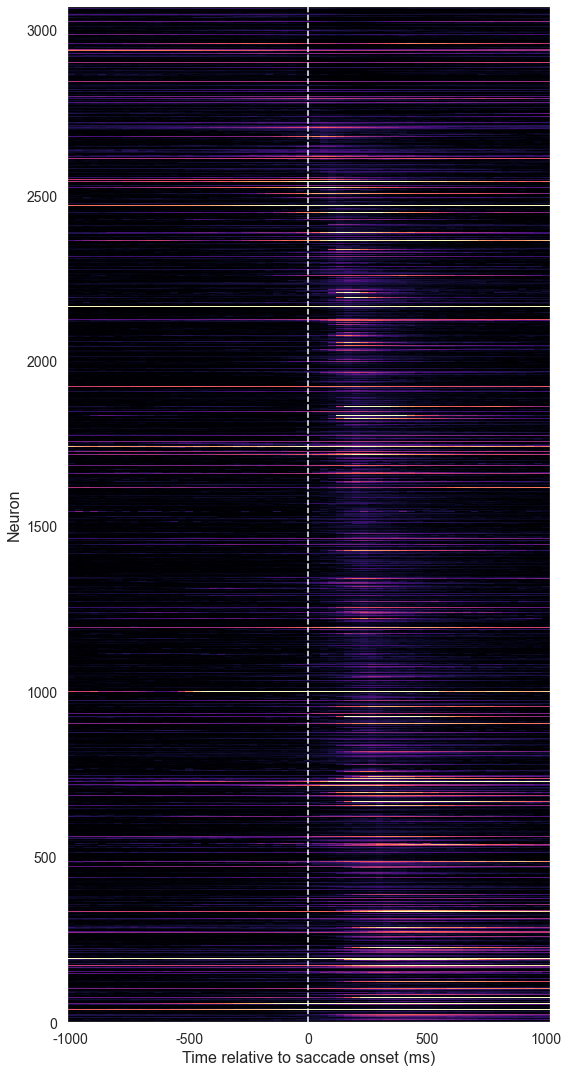

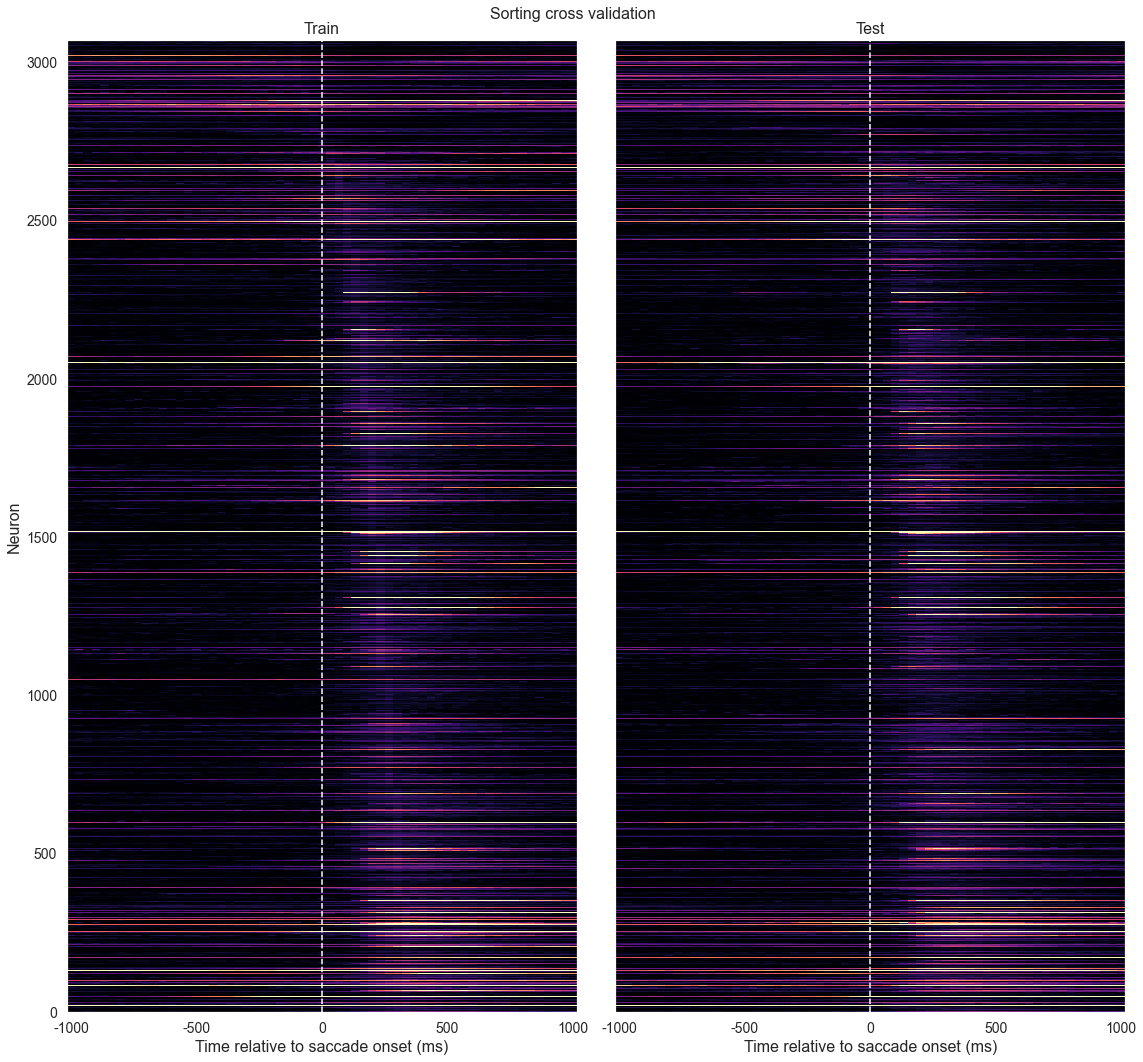

In [33]:
peak_dff_window = slice(window_radius-3, window_radius+11) # 3 frames before onset to 10 frames after
peak_dff_frame = np.argmax(cell_mean_traces[:, peak_dff_window], axis=1)
mask = cells.index[cells["is_sr"]].isin(cells_and_metrics.index)
cells_and_metrics.loc[cells_and_metrics.index[cells_and_metrics["is_sr"]], "peak_dff_frame"] = peak_dff_frame[mask]
sort_idx = np.argsort(-peak_dff_frame)
# sort_idx = sort_idx[:200]

fig, ax = plt.subplots(figsize=(8, 15), facecolor="white")
sorted_traces = cell_mean_traces[sort_idx]
vmin = 0 # np.percentile(sorted_traces, 1)
vmax = np.percentile(sorted_traces, 99)
cax = ax.pcolormesh(sorted_traces, cmap="magma", vmin=vmin, vmax=vmax)
# cb = fig.colorbar(cax, pad=0.015, label="dF/F")
set_major_minor_ticks(ax, window_radius, center=window_radius+0.5) # 0.5 center so it aligns at the center of the color cell
ax.axvline(window_radius+0.5, color="white", linestyle="dashed")
ax.set_ylabel("Neuron", fontsize=16)
ax.set_xlabel("Time relative to saccade onset (ms)", fontsize=16)
plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
fig.tight_layout()

# Validation
fig, axs = plt.subplots(ncols=2, figsize=(16, 15), facecolor="white")
peak_dff_frame = np.argmax(cell_mean_traces_train[:, peak_dff_window], axis=1)
sort_idx = np.argsort(-peak_dff_frame)

axs[0].pcolormesh(cell_mean_traces_train[sort_idx], cmap="magma", vmin=0, vmax=np.percentile(cell_mean_traces_train, 99))
axs[0].set_title("Train", fontsize=16)
axs[1].pcolormesh(cell_mean_traces_test[sort_idx], cmap="magma", vmin=0, vmax=np.percentile(cell_mean_traces_test, 99))
axs[1].set_title("Test", fontsize=16)

for i, ax in enumerate(axs):
    set_major_minor_ticks(ax, window_radius, center=window_radius+0.5) # 0.5 center so it aligns at the center of the color cell
    ax.axvline(window_radius+0.5, color="white", linestyle="dashed")
    if i == 0:
        ax.set_ylabel("Neuron", fontsize=16)
    else:
        ax.yaxis.set_visible(False)
    ax.set_xlabel("Time relative to saccade onset (ms)", fontsize=16)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)

fig.suptitle("Sorting cross validation", fontsize=16)
fig.tight_layout()

# Visualize how many cells respond

In [32]:
df_rows = []

for cre_line in CRE_ORDERING:
    for targeted_structure in AREA_ORDERING:
        df = cells[(cells[CRE_PLOT_KEY] == cre_line) & (cells["targeted_structure"] == targeted_structure)]
        n_cells = len(df)

        if n_cells > 0:
            df_responsive = df[df["is_sr"]]
            n_responsive = len(df_responsive)

            df_responsive_miura = df[df["is_sr_miura"]]
            n_responsive_miura = len(df_responsive_miura)

            df_rows.append({
                CRE_PLOT_KEY: cre_line,
                "targeted_structure": targeted_structure,
                "n_cells": n_cells,
                "n_cells_responsive": n_responsive,
                "frac_responsive": n_responsive/n_cells,
                "n_cells_responsive_miura": n_responsive_miura,
                "frac_responsive_miura": n_responsive_miura/n_cells,
            })

responses_by_cre_and_area = pd.DataFrame(df_rows)
responses_by_cre_and_area.head()

,cre_abbrev,targeted_structure,n_cells,n_cells_responsive,frac_responsive,n_cells_responsive_miura,frac_responsive_miura
0,Emx1;Ai93,VISp,646,22,0.034056,189,0.292570
1,Emx1;Ai93,VISl,886,98,0.110609,544,0.613995
2,Emx1;Ai93,VISal,772,59,0.076425,439,0.568653
3,Emx1;Ai93,VISpm,274,11,0.040146,77,0.281022
4,Emx1;Ai93,VISam,363,84,0.231405,172,0.473829


In [33]:
df = responses_by_cre_and_area.pivot(CRE_PLOT_KEY, "targeted_structure", "n_cells")
df = df.reindex(CRE_ORDERING, axis=0).reindex(AREA_ORDERING, axis=1)#.reindex(columns=[AREA_ABBREV[a] for a in AREA_ORDERING])
df.columns = [AREA_ABBREV[a] for a in df.columns]
df.head()

,V1,LM,AL,PM,AM,RL
cre_abbrev,,,,,,
Emx1;Ai93,646.0,886.0,772.0,274.0,363.0,2079.0
Slc17a7;Ai93,3671.0,2033.0,338.0,1293.0,235.0,137.0
Slc17a7;Ai94,817.0,NaN,NaN,NaN,NaN,NaN
Cux2;Ai93,1504.0,1461.0,1055.0,1038.0,916.0,1017.0
Rorb;Ai93,849.0,683.0,299.0,292.0,385.0,977.0


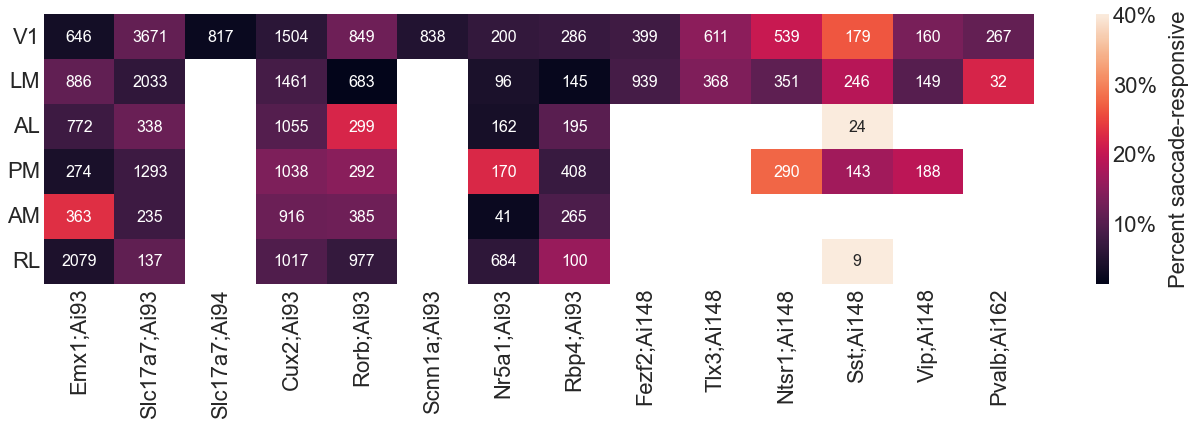

In [35]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(18, 6), facecolor="w")
    x, xorder = CRE_PLOT_KEY, CRE_ORDERING
    y, yorder, ylabels = "targeted_structure", AREA_ORDERING, [AREA_ABBREV[a] for a in AREA_ORDERING]
    frac_responsive = responses_by_cre_and_area.pivot(y, x, "frac_responsive")
    n_cells = responses_by_cre_and_area.pivot(y, x, "n_cells")

    frac_responsive = frac_responsive.reindex(yorder, axis=0).reindex(xorder, axis=1)
    n_cells = n_cells.reindex(yorder, axis=0).reindex(xorder, axis=1)

    # sns.heatmap(frac_responsive, annot=n_cells, fmt=".0f", cmap="magma", ax=axs[0], vmin=0, vmax=1)
    # sns.heatmap(frac_responsive_miura, annot=n_cells, fmt=".0f", cmap="magma", ax=axs[1], vmin=0, vmax=1)
    sns.heatmap(frac_responsive, annot=n_cells, fmt=".0f", ax=ax, annot_kws=dict(fontsize=16), vmax=0.4)
    # sns.heatmap(frac_responsive_miura, annot=n_cells, fmt=".0f", ax=axs[1], annot_kws=dict(fontsize=16))
    plt.setp(ax, xlabel="", ylabel="")
    plt.setp(ax.get_xticklabels(), fontsize=22, rotation=90)
    ax.set_yticklabels(ylabels, fontsize=22, rotation=0)
    # ax.set_yticklabels(CRE_LINE_REPORTER_ORDERING, fontsize=18, rotation=0)
    # ax.set_title("Fraction of SR cells by cre and region (n = total no. imaged cells)", fontsize=22)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels([f"{tick*100:.0f}%" for tick in cbar.get_ticks()])
    cbar.set_label("Percent saccade-responsive", fontsize=22, labelpad=12, va="top") # , rotation=270, va="bottom"

    # axs[1].set_title("Significance method: Miura", fontsize=18)
    fig.tight_layout()
    savefig(fig, "fraction_responsive_heatmap.png") 

cre_abbrev    is_sr
Cux2;Ai93     False    6331
              True      660
Emx1;Ai93     False    4656
              True      364
Fezf2;Ai148   False    1228
              True      110
Nr5a1;Ai93    False    1249
              True      104
Ntsr1;Ai148   False     952
              True      228
Pvalb;Ai162   False     262
              True       37
Rbp4;Ai93     False    1287
              True      112
Rorb;Ai93     False    3150
              True      335
Scnn1a;Ai93   False     797
              True       41
Slc17a7;Ai93  False    6996
              True      711
Slc17a7;Ai94  False     798
              True       19
Sst;Ai148     False     469
              True      132
Tlx3;Ai148    False     836
              True      143
Vip;Ai148     False     425
Name: is_sr, dtype: int64


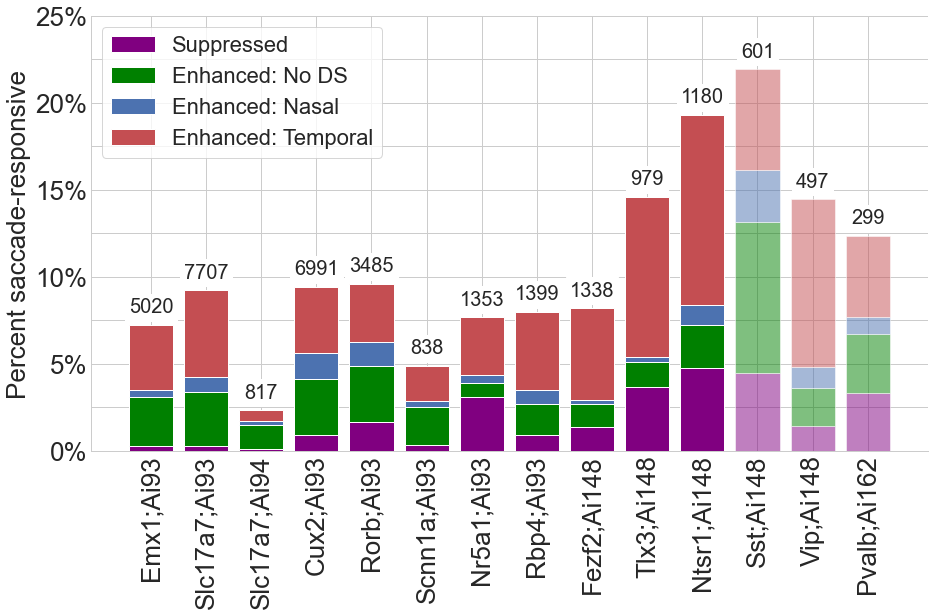

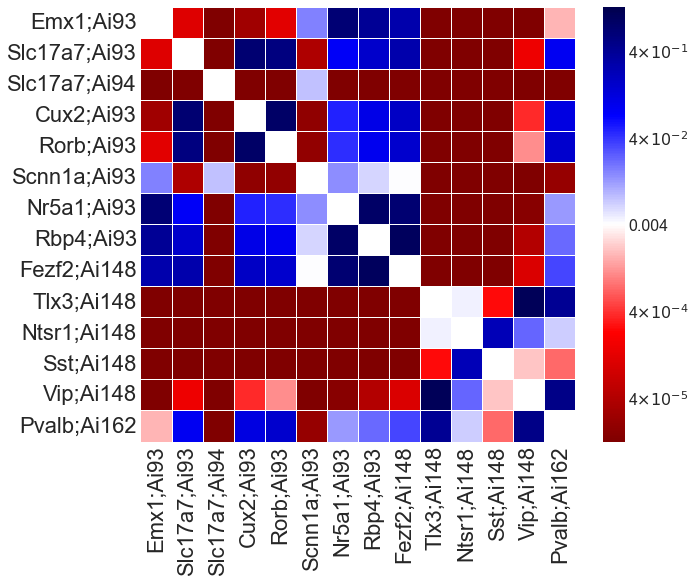

In [37]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(15, 8), facecolor="white")
    bottom = None
    df = cells["sr_label"].groupby(cells[CRE_PLOT_KEY]).value_counts(normalize=True)

    for sr_label, color in SR_LABELS:
        if sr_label == "No response": continue
        heights = []
        excitatory = []
        for cre in CRE_ORDERING:
            heights.append(df[cre][sr_label] if sr_label in df[cre] else 0)
            cre_line = match_cre_line(cre)
            excitatory.append(cre_line.is_excitatory)

        bar_container = ax.bar(CRE_ORDERING, heights, bottom=bottom, label=sr_label, color=color)

        for patch, is_excitatory in zip(bar_container.patches, excitatory):
            if not is_excitatory:
                # patch.set_hatch("ooo")
                patch.set_alpha(0.5)

        bottom = heights if bottom is None else bottom + np.array(heights)

    ax.legend(fontsize=22, frameon=True, loc="upper left")
    plt.setp(ax.get_xticklabels(), fontsize=26, rotation=90)
    ax.set_xlabel("")
    ax.set_ylim(0, 0.2)
    yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25]
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick}%" if int(tick) == tick else None for tick in yticks], fontsize=26)
    ax.set_ylabel("Percent saccade-responsive", fontsize=26)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # for text, cre in zip(ax.get_xticklabels(), CRE_ORDERING):
    #     text.set_bbox(dict(facecolor=match_cre_line(cre).color, alpha=0.5))

    bar_labels = [np.sum(cells[CRE_PLOT_KEY] == cre) for cre in CRE_ORDERING]
    ax.bar_label(ax.containers[-1], labels=bar_labels, fmt="%d", padding=8, fontsize=20, backgroundcolor="w")
    savefig(fig, "fraction_responsive_by_cre.png")

    # Generate probability matrix
    p_matrix = np.zeros((len(CRE_ORDERING), len(CRE_ORDERING)), dtype=float)
    counts = cells.groupby(CRE_PLOT_KEY)["is_sr"].value_counts()

    print(counts.head(-1))
            
    for i in range(len(CRE_ORDERING)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(CRE_ORDERING)):
            observed = [
                [counts[CRE_ORDERING[i]][True], counts[CRE_ORDERING[i]][False]],
                [counts[CRE_ORDERING[j]][True], counts[CRE_ORDERING[j]][False]]
            ]
            p_val = stats.chi2_contingency(observed)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val

    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=CRE_ORDERING, title=f"", ticklabelfontsize=22, figsize=(10, 8))
    savefig(fig, "sr_by_cre_proba.png")

targeted_structure  is_sr
VISal               False    2540
                    True      305
VISam               False    1921
                    True      284
Name: is_sr, dtype: int64


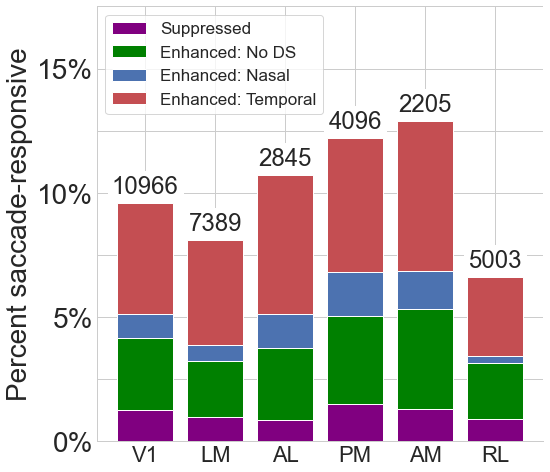

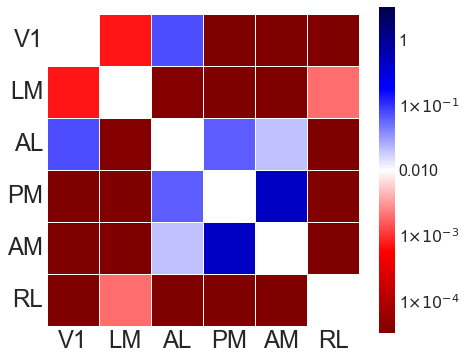

In [38]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 8), facecolor="white")
    bottom = None
    df = cells["sr_label"].groupby(cells["targeted_structure"]).value_counts(normalize=True)
    areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

    for sr_label, color in SR_LABELS:
        if sr_label == "No response": continue
        heights = []
        for area in AREA_ORDERING:
            heights.append(df[area][sr_label] if sr_label in df[area] else 0)
        ax.bar(areas, heights, bottom=bottom, label=sr_label, color=color)
        heights = np.array(heights)
        bottom = heights if bottom is None else bottom + heights

    # ax.bar(agg_tips.index, agg_tips['Female'], bottom=agg_tips['Male'],
    # label='Female')
    # ax.set_title('Tips by Day and Gender')
    ax.legend(fontsize=17, frameon=True, loc="upper left")
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=22)
    ax.set_xlabel("")
    yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick}%" if int(tick) == tick else None for tick in yticks], fontsize=28)
    ax.set_ylabel("Percent saccade-responsive", fontsize=28)

    bar_labels = [np.sum(cells["targeted_structure"] == area) for area in AREA_ORDERING]
    ax.bar_label(ax.containers[-1], labels=bar_labels, fmt="{}", padding=5, fontsize=24, backgroundcolor="w")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    savefig(fig, "fraction_responsive_by_area.png")

    # Generate probability matrix
    p_matrix = np.zeros((len(AREA_ORDERING), len(AREA_ORDERING)), dtype=float)
    counts = cells.groupby("targeted_structure")["is_sr"].value_counts()

    print(counts.head(4))
            
    for i in range(len(AREA_ORDERING)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(AREA_ORDERING)):
            observed = [
                [counts[AREA_ORDERING[i]][True], counts[AREA_ORDERING[i]][False]],
                [counts[AREA_ORDERING[j]][True], counts[AREA_ORDERING[j]][False]]
            ]
            p_val = stats.chi2_contingency(observed)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val

    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=areas, title=f"", figsize=(7, 6), ticklabelfontsize=24, xticklabelrotation=0)
    savefig(fig, "sr_by_area_proba.png")

In [39]:
cells["is_sr"].groupby(cells["targeted_structure"]).value_counts(normalize=False)

targeted_structure  is_sr
VISal               False    2540
                    True      305
VISam               False    1921
                    True      284
VISl                False    6790
                    True      599
VISp                False    9916
                    True     1050
VISpm               False    3596
                    True      500
VISrl               False    4673
                    True      330
Name: is_sr, dtype: int64

In [64]:
cells.sr_label.value_counts()

No response           26629
Enhanced: No DS         603
Enhanced: Temporal      342
Suppressed              257
Enhanced: Nasal          81
Name: sr_label, dtype: int64

# Direction selectivity

SR: -0.11, 0.34, 0.78 (mean = 0.26 ± 1.96)
SR-DS-R: 0.66, 0.89, 1.23 (mean = 1.00 ± 0.53)
SR-DS-L: -1.08, -0.84, -0.57 (mean = -1.13 ± 2.54)


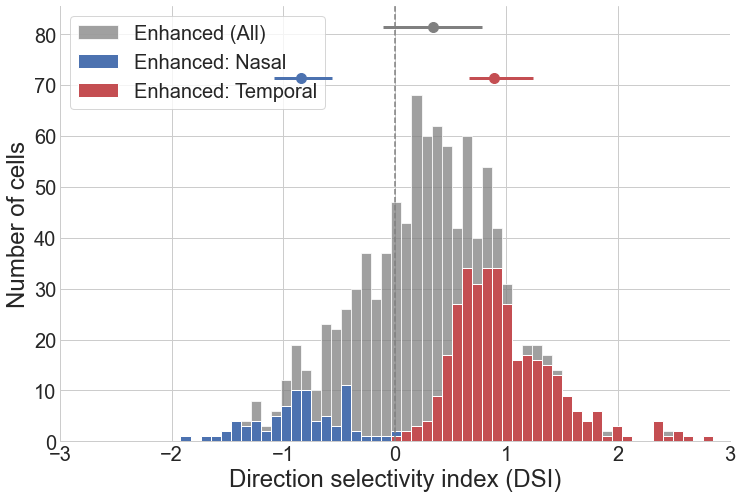

In [58]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

    is_sr = cells["response_classification"] == 1
    values = cells[is_sr]["direction_selectivity"].dropna().values
    # values = cells["direction_selectivity"].dropna().values # all cells
    p25_sr, p50_sr, p75_sr = np.quantile(values, [0.25, 0.5, 0.75])
    print(f"SR: {p25_sr:.2f}, {p50_sr:.2f}, {p75_sr:.2f} (mean = {values.mean():.2f} ± {values.std():.2f})")
    values = values[(-10 < values) & (values < 10)]
    xlim = -3, 3
    n, bins, _ = ax.hist(values, bins=np.arange(*xlim, 0.09), color="gray", alpha=0.75, label="Enhanced (All)")

    ds_inclusion = is_sr & (cells["is_sr_ds"])
    srds_R = cells[ds_inclusion & (cells["preferred_direction"] == 1)]["direction_selectivity"].dropna().values
    srds_L = cells[ds_inclusion & (cells["preferred_direction"] == -1)]["direction_selectivity"].dropna().values
    # srds_R = cells[is_sr & (cells["mean_right_response"].abs() >= 2*cells["mean_left_response"])]["direction_selectivity"].dropna().values
    # srds_L = cells[is_sr & (cells["mean_left_response"].abs() >= 2*cells["mean_right_response"])]["direction_selectivity"].dropna().values
    p25_R, p50_R, p75_R = np.quantile(srds_R, [0.25, 0.5, 0.75])
    p25_L, p50_L, p75_L = np.quantile(srds_L, [0.25, 0.5, 0.75])
    print(f"SR-DS-R: {p25_R:.2f}, {p50_R:.2f}, {p75_R:.2f} (mean = {srds_R.mean():.2f} ± {srds_R.std():.2f})")
    print(f"SR-DS-L: {p25_L:.2f}, {p50_L:.2f}, {p75_L:.2f} (mean = {srds_L.mean():.2f} ± {srds_L.std():.2f})")
    srds_L = srds_L[(-10 < srds_L) & (srds_L < 10)]
    srds_R = srds_R[(-10 < srds_R) & (srds_R < 10)]
    ax.hist(srds_L, bins=bins, alpha=1, color="b", label="Enhanced: Nasal")
    ax.hist(srds_R, bins=bins, alpha=1, color="r", label="Enhanced: Temporal")

    ax.set_xlim(*xlim)
    y = ax.get_ylim()[1]

    ax.scatter(p50_sr, y+10, color="gray", s=100, zorder=10)
    ax.hlines(xmin=p25_sr, xmax=p75_sr, y=y+10, color="gray", linewidth=3, zorder=10)

    ax.scatter(p50_L, y, color="b", s=100, zorder=10)
    ax.hlines(xmin=p25_L, xmax=p75_L, y=y, color="b", linewidth=3, zorder=10)

    ax.scatter(p50_R, y, color="r", s=100, zorder=10)
    ax.hlines(xmin=p25_R, xmax=p75_R, y=y, color="r", linewidth=3, zorder=10)

    ax.axvline(0, color="gray", linestyle="dashed")

    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=20)
    ax.set_xlabel("Direction selectivity index (DSI)", fontsize=24)
    ax.set_ylabel("Number of cells", fontsize=24)
    ax.legend(fontsize=20, loc="upper left", frameon=True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    savefig(fig, "direction_selectivity_spontaneous.png")
    # savefig(fig, "direction_selectivity.png")

    # ax.set_title("Direction selectivity")

mean no pref N/T: 0.0351, 0.0460
mean nasal N/T: 0.1093, 0.0073
mean temporal N/T: 0.0020, 0.0743
n_sr_enhanced: 1026
no_pref: 603
nasal: 81
temporal: 342


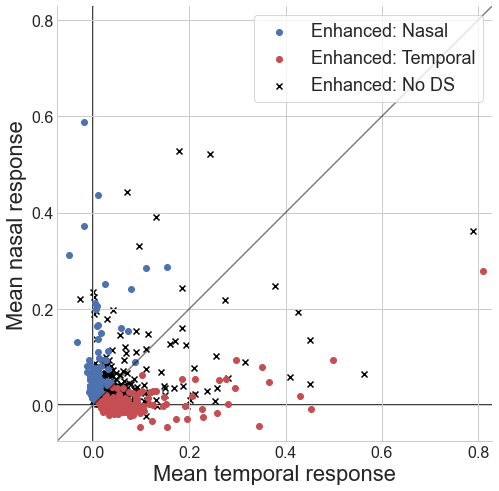

In [59]:
def plot_yeqx(ax, **kwargs):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, zorder=1, **kwargs)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 8), facecolor="white")
    x = cells["mean_right_response"].values
    y = cells["mean_left_response"].values

    is_sr = cells["response_classification"] == 1
    n_sr = is_sr.sum()
    no_pref = is_sr & ~(cells["is_sr_ds"])
    nasal = is_sr & (cells["preferred_direction"] == -1)
    nasal_suppressed = is_sr & (cells["preferred_direction"] == -1)
    temporal = is_sr & (cells["preferred_direction"] == 1)

    ax.scatter(x[nasal], y[nasal], color="b", alpha=1, label=f"Enhanced: Nasal") # ({nasal.sum()/n_sr*100:.1f}%)
    ax.scatter(x[temporal], y[temporal], color="r", alpha=1, label=f"Enhanced: Temporal") # ({temporal.sum()/n_sr*100:.1f}%)
    ax.scatter(x[no_pref], y[no_pref], color="black", marker="x", label=f"Enhanced: No DS", zorder=0) # ({no_pref.sum()/n_sr*100:.1f}%)

    print(f"mean no pref N/T: {y[no_pref].mean():.4f}, {x[no_pref].mean():.4f}")
    print(f"mean nasal N/T: {y[nasal].mean():.4f}, {x[nasal].mean():.4f}")
    print(f"mean temporal N/T: {y[temporal].mean():.4f}, {x[temporal].mean():.4f}")

    ax.set_xlabel("Mean temporal response", fontsize=22)
    ax.set_ylabel("Mean nasal response", fontsize=22)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    print(f"n_sr_enhanced: {n_sr}")
    print(f"no_pref: {no_pref.sum()}")
    print(f"nasal: {nasal.sum()}")
    print(f"temporal: {temporal.sum()}")

    ax.legend(loc="upper right", fontsize=18, frameon=True)
    ax.set_xlim(-0.075, np.quantile(x[cells["is_sr"]], [0.995]))
    ax.set_ylim(-0.075, np.quantile(y[cells["is_sr"]], [0.995]))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plot_yeqx(ax, color="black", alpha=0.5)
    ax.axhline(y=0, color="black", zorder=0)
    ax.axvline(x=0, color="black", zorder=0)
    savefig(fig, "direction_selectivity_scatter_spontaneous.png")
    # savefig(fig, "direction_selectivity_scatter.png")

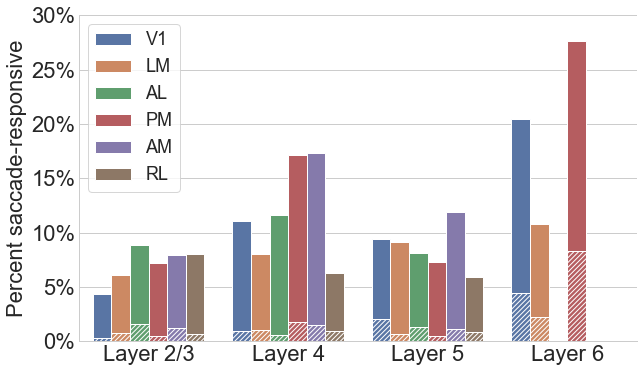

In [42]:
order = sorted(cells["cortical_layer"].unique())

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
    bar = sns.barplot(data=cells, x="cortical_layer", ci=None, y="is_sr", hue="targeted_structure", ax=ax, order=order, hue_order=AREA_ORDERING)
    patches1 = bar.patches[:]

    legend_handles = ax.legend_.legendHandles
    bar2 = sns.barplot(x=cells["cortical_layer"], ci=None, y=(cells["response_classification"] == -1), hue=cells["targeted_structure"], ax=ax, order=order, hue_order=AREA_ORDERING)

    for patch in bar2.patches:
        if patch not in patches1:
            patch.set_hatch("/////")

    # ax.set_title("SUPPRESSED", fontsize=16)
    # ax.set_xlabel("Cortical layer", fontsize=16)
    ax.set_xlabel("")
    ax.set_xticklabels([f"Layer {l}" for l in order], fontsize=22)
    ax.set_ylabel("Percent saccade-responsive", fontsize=22)
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
    ax.set_ylim(min(ax.get_yticks()), max(ax.get_yticks()))
    ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ax.get_yticks()])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False) 
    plt.setp(ax.get_yticklabels(), fontsize=22)
    ax.legend(handles=legend_handles, labels=[AREA_ABBREV[area] for area in ax.get_legend_handles_labels()[1]], fontsize=18, frameon=True)
    savefig(fig, "frac_responsive_by_layer_across_areas.png")

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator


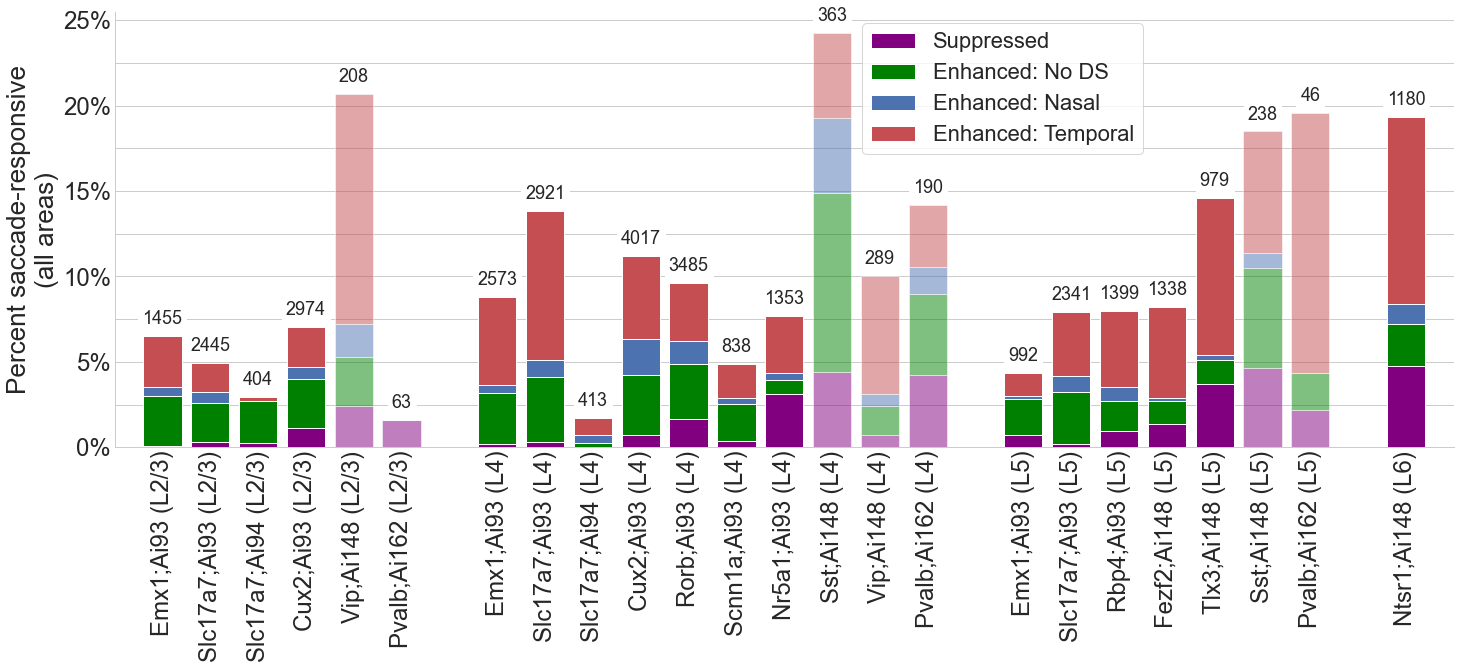

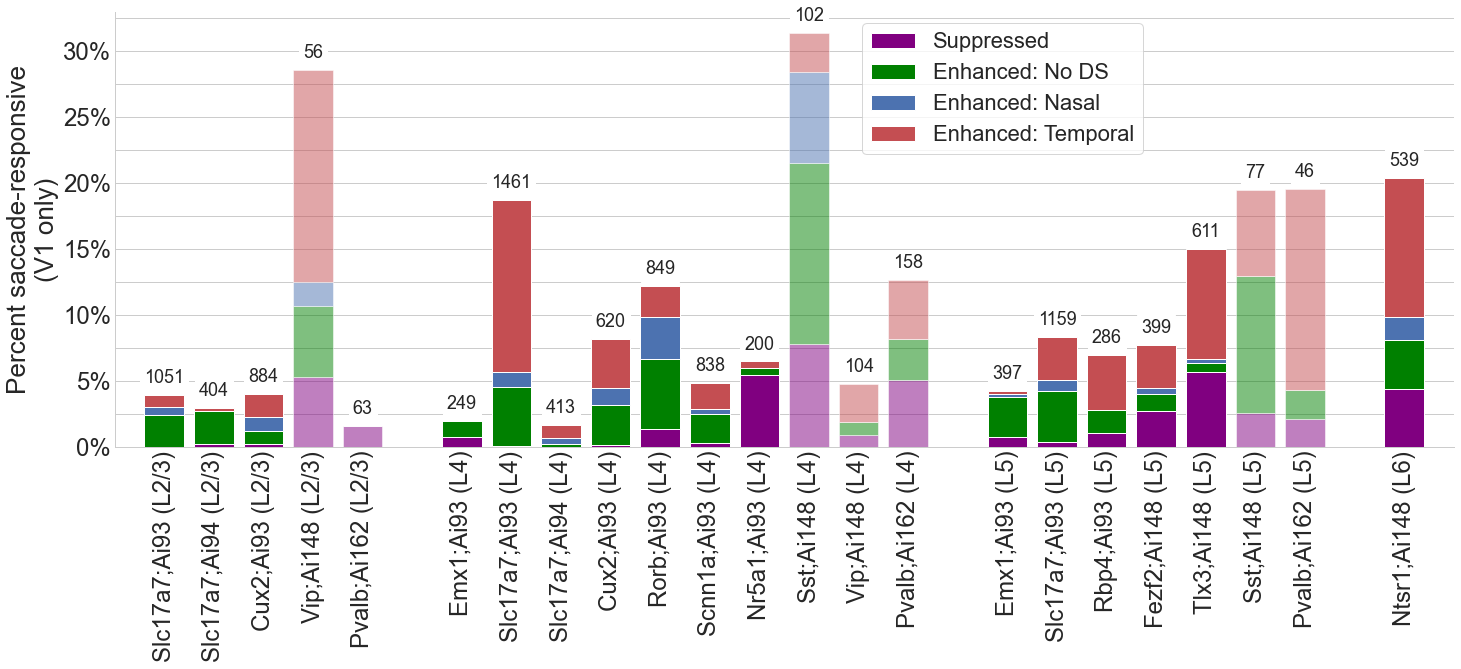

In [43]:
for v1_only in [False, True]: # Whether to plot only V1 cells
    df = cells[cells.targeted_structure == "VISp"] if v1_only else cells
    # df = cells[cells.targeted_structure == "VISp"] if v1_only else cells[cells.targeted_structure != "VISp"]
    cre_and_layer = []
    all_layers = sorted(df["cortical_layer"].unique())
    tick_labels_unique = []
    tick_labels = []
    bar_labels = []

    for i, layer in enumerate(all_layers):
        for cre in CRE_ORDERING:
            mask = (df[CRE_PLOT_KEY] == cre) & (df["cortical_layer"] == layer)
            n_cells = mask.sum()
            if n_cells > 0:
                cre_and_layer.append((cre, layer))
                tick_labels.append(f"{cre} (L{layer})")
                # bar_labels.append(f"{(mask & (cells['is_sr'])).sum()}/{n_cells}")
                bar_labels.append(f"{n_cells}")

        if i < len(all_layers) - 1:
            cre_and_layer.append((None, None))
            tick_labels.append("")
            bar_labels.append("")

    tick_labels_unique = [str(i) for i in range(len(tick_labels))]

    with plt.style.context("seaborn-whitegrid"):
        fig, ax = plt.subplots(figsize=(24, 8), facecolor="white")
        bottom = None
        df = df.groupby(by=[CRE_PLOT_KEY, "cortical_layer"])["sr_label"].value_counts(normalize=True)

        for sr_label, color in SR_LABELS:
            if sr_label == "No response": continue
            heights = []
            excitatory = []

            for cre, layer in cre_and_layer:
                if layer == None:
                    heights.append(0)
                    is_excitatory = True
                else:
                    heights.append(df[cre][layer][sr_label] if sr_label in df[cre][layer] else 0)
                    cre_line = match_cre_line(cre)
                    is_excitatory = cre_line.is_excitatory

                excitatory.append(is_excitatory)

            bar_container = ax.bar(tick_labels_unique, heights, bottom=bottom, label=sr_label, color=color)

            for patch, is_excitatory in zip(bar_container.patches, excitatory):
                if not is_excitatory:
                    # patch.set_hatch("ooo")
                    patch.set_alpha(0.5)

            bottom = heights if bottom is None else bottom + np.array(heights)

        ax.legend(fontsize=22, frameon=True, bbox_to_anchor=(0.55, 1), loc="upper left",  bbox_transform=ax.transAxes)
        ax.set_xticklabels(tick_labels, fontsize=24, rotation=90)
        # plt.setp(ax.get_xticklabels(), )
        ax.set_xlabel("")
        # ax.set_ylim(0, 0.2)
        yticks = np.arange(0, ax.get_ylim()[1]*100, 2.5)
        ax.set_yticks([tick/100 for tick in yticks])
        ax.set_yticklabels([f"{tick:.0f}%" if int(tick) == tick else None for tick in yticks], fontsize=24)
        if v1_only:
            ax.set_ylabel("Percent saccade-responsive\n(V1 only)", fontsize=26)
        else:
            ax.set_ylabel("Percent saccade-responsive\n(all areas)", fontsize=26)
            
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)    
        ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
        ax.xaxis.grid(False) # Remove vertical grid lines
        ax.set_xlim(-1, len(tick_labels))

        if v1_only:
            savefig(fig, "frac_responsive_by_cre_and_layer_v1.png")
        else:
            savefig(fig, "frac_responsive_by_cre_and_layer.png")

In [248]:
# Count the SR cells by cre/layer
cells.groupby(by=[CRE_PLOT_KEY, "cortical_layer"])["is_sr"].value_counts()

cre_abbrev     cortical_layer  is_sr
Cux2; Ai93     2/3             False    2758
                               True      207
               4               False    3411
                               True      456
Emx1; Ai93     2/3             False    1360
                               True       95
               4               False    2340
                               True      233
               5               False     954
                               True       38
Fezf2; Ai148   5               False    1230
                               True      108
Nr5a1; Ai93    4               False    1249
                               True      104
Ntsr1; Ai148   6               False     951
                               True      229
Pvalb; Ai162   2/3             False      62
                               True        1
               4               False     165
                               True       25
               5               False      36
                  

No handles with labels found to put in legend.
/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


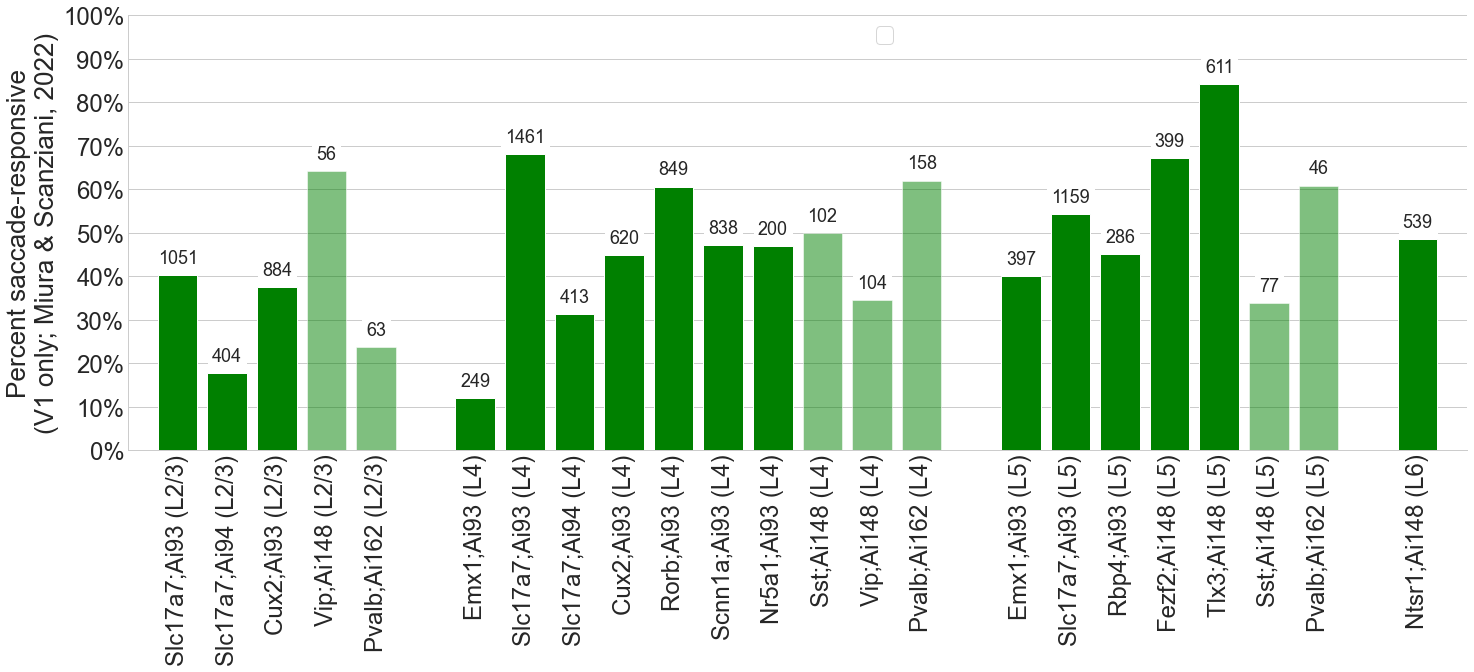

In [44]:
v1_only = True
df = cells[cells.targeted_structure == "VISp"] if v1_only else cells

cre_and_layer = []
all_layers = sorted(df["cortical_layer"].unique())
tick_labels_unique = []
tick_labels = []
bar_labels = []

for i, layer in enumerate(all_layers):
    for cre in CRE_ORDERING:
        mask = (df[CRE_PLOT_KEY] == cre) & (df["cortical_layer"] == layer)
        n_cells = mask.sum()
        if n_cells > 0:
            cre_and_layer.append((cre, layer))
            tick_labels.append(f"{cre} (L{layer})")
            # bar_labels.append(f"{(mask & (cells['is_sr'])).sum()}/{n_cells}")
            bar_labels.append(f"{n_cells}")

    if i < len(all_layers) - 1:
        cre_and_layer.append((None, None))
        tick_labels.append("")
        bar_labels.append("")

tick_labels_unique = [str(i) for i in range(len(tick_labels))]

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(24, 8), facecolor="white")
    bottom = None
    df = df.groupby(by=[CRE_PLOT_KEY, "cortical_layer"])["is_sr_miura"].mean()
    heights = []
    excitatory = []

    for cre, layer in cre_and_layer:
        if layer == None:
            heights.append(0)
            is_excitatory = True
        else:
            heights.append(df[cre][layer] if layer in df[cre] else 0)
            cre_line = match_cre_line(cre)
            is_excitatory = cre_line.is_excitatory

        excitatory.append(is_excitatory)

    bar_container = ax.bar(tick_labels_unique, heights, color="green")

    for patch, is_excitatory in zip(bar_container.patches, excitatory):
        if not is_excitatory:
            # patch.set_hatch("ooo")
            patch.set_alpha(0.5)

    ax.legend(fontsize=22, frameon=True, bbox_to_anchor=(0.55, 1), loc="upper left",  bbox_transform=ax.transAxes)
    ax.set_xticklabels(tick_labels, fontsize=24, rotation=90)
    # plt.setp(ax.get_xticklabels(), )
    ax.set_xlabel("")
    # ax.set_ylim(0, 0.2)
    yticks = np.arange(0, 101, 10)
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick:.0f}%" if int(tick) == tick else None for tick in yticks], fontsize=24)
    # ax.set_ylabel("Percent saccade-responsive (all areas)", fontsize=26)
    if v1_only:
        ax.set_ylabel("Percent saccade-responsive\n(V1 only; Miura & Scanziani, 2022)", fontsize=26)
    else:
        ax.set_ylabel("Percent saccade-responsive\n(all areas; Miura & Scanziani, 2022)", fontsize=26)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
    ax.xaxis.grid(False) # Remove vertical grid lines
    ax.set_xlim(-1, len(tick_labels))
    # savefig(fig, "frac_responsive_by_cre_and_layer.png")

    if v1_only:
        savefig(fig, "frac_responsive_by_cre_and_layer_miura_v1.png")
    else:
        savefig(fig, "frac_responsive_by_cre_and_layer_miura.png")

In [45]:
cells_and_metrics["pref_ori_dg"][cells_and_metrics["responsive_dg"] == True].dropna().groupby(cells_and_metrics["sr_label"]).value_counts(normalize=True).rename("fraction")

sr_label            pref_ori_dg
Enhanced: Nasal     0.0            0.170068
                    315.0          0.163265
                    180.0          0.142857
                    90.0           0.129252
                    270.0          0.115646
                    45.0           0.108844
                    135.0          0.088435
                    225.0          0.081633
Enhanced: No DS     0.0            0.185714
                    180.0          0.154286
                    45.0           0.131429
                    90.0           0.122857
                    225.0          0.117143
                    135.0          0.108571
                    315.0          0.091429
                    270.0          0.088571
Enhanced: Temporal  0.0            0.226381
                    180.0          0.144385
                    90.0           0.133690
                    45.0           0.117647
                    225.0          0.112299
                    135.0          0.092692


In [46]:
df = cells_and_metrics[(cells_and_metrics["responsive_sg"] == True) & (cells_and_metrics["is_sr"])]["pref_sf_sg"].groupby(cells_and_metrics["peak_dff_frame"]).value_counts(normalize=True).to_frame("percent").reset_index()
# label = SR_LABELS[3][0]
# df = cells_and_metrics[(cells_and_metrics["responsive_sg"] == True) & (cells_and_metrics["sr_label"] == label)]["pref_sf_sg"].groupby(cells_and_metrics["peak_dff_frame"]).value_counts(normalize=True).to_frame("percent").reset_index()
pivot_df = df.pivot("peak_dff_frame", "pref_sf_sg", "percent")
fig, ax = plt.subplots(figsize=(8, 12), facecolor="white")
sns.heatmap(data=pivot_df, ax=ax)

KeyError: 'peak_dff_frame'

In [47]:
cells_and_metrics[(cells_and_metrics["responsive_sg"] == True) & ~(cells_and_metrics["is_sr"])]["pref_sf_sg"].value_counts(normalize=True)

0.02    0.364888
0.04    0.288578
0.08    0.238590
0.32    0.056508
0.16    0.051437
Name: pref_sf_sg, dtype: float64

In [48]:
df = cells_and_metrics[(cells_and_metrics["responsive_dg"] == True) & (cells_and_metrics["is_sr"])]["pref_tf_dg"].groupby(cells_and_metrics["peak_dff_frame"]).value_counts(normalize=True).to_frame("percent").reset_index()
# label = SR_LABELS[4][0]
# df = cells_and_metrics[(cells_and_metrics["responsive_dg"] == True) & (cells_and_metrics["sr_label"] == label)]["pref_tf_dg"].groupby(cells_and_metrics["peak_dff_frame"]).value_counts(normalize=True).to_frame("percent").reset_index()
pivot_df = df.pivot("peak_dff_frame", "pref_tf_dg", "percent")
fig, ax = plt.subplots(figsize=(8, 12), facecolor="white")
sns.heatmap(data=pivot_df, ax=ax)

KeyError: 'peak_dff_frame'

In [80]:
cells_and_metrics[(cells_and_metrics["responsive_dg"] == True) & ~(cells_and_metrics["is_sr"])]["pref_tf_dg"].value_counts(normalize=True)

1.0     0.422361
2.0     0.188421
4.0     0.154051
8.0     0.125307
15.0    0.109861
Name: pref_tf_dg, dtype: float64